# Image Classification using EfficientNet

This Code Template is for simple image classification using EfficientNet.

### Required Packages

In [4]:
import os
import numpy as np
from glob import glob
import itertools
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

# TensorFlow Modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB0

# Visualizations
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns

### Initialization
Path of the main folder containing train and test folders

In [26]:
base_dir = os.path.dirname('')

Path of the train and test folders containing image files

In [27]:
train_dir = os.path.join(base_dir, 'train') #train
test_dir = os.path.join(base_dir, 'test') #test

List of target categories which are required for model training and predictions.

In [29]:
target = []

### Data Fetching

The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.

OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

We will use the <Code>os.path</Code> module to interact with the file system and the <Code>cv2.imread()</Code> method to load an image from the specified file path.

### Directory Structure
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [30]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

In [31]:
# Loading the image dataset and plotting some images from all target categories
def plot_image(data, target):
  count = 0
  for category in target:
      path=os.path.join(data, category)
      flg = 0
      ar = []
      # storing image paths in an array
      for img in os.listdir(path):
          ar.append(os.path.join(path,img)) 
          flg+= 1
          if flg==2:
            break
      # plotting the images in dataset
      plt.figure(figsize=(5,5))
      for i in range(2):
        d1 = ar[i]
        img_array = cv2.imread(d1,cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1,2,i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
      count+= 1
      if count == len(target):
        break

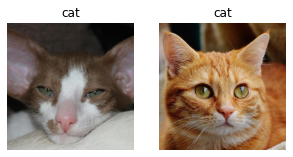

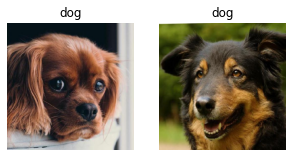

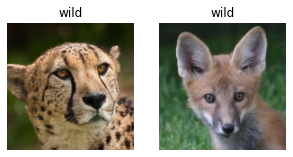

In [34]:
plot_image(train_dir,target)

### Data Preprocessing

An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.   

TensorFlow 2 comes with a handy class called <Code>ImageDataGenerator</Code> that augments images. It takes the following parameters:


1. **rotation_range**:	Int. 
>Degree range for random rotations.

2. **width_shift_range**: Float, 1-D array-like or int
          * float: fraction of total width, if < 1, or pixels if >= 1.
          * 1-D array-like: random elements from the array.
          * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
          * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

3. **height_shift_range**:	Float, 1-D array-like or int. 
>Values have similar meaning as width_shift_range

4. **zoom_range**:	Float or [lower, upper]. 
>Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range	Float. Range for random channel shifts.

5. **horizontal_flip**:	Boolean. 
>Randomly flip inputs horizontally.


6. **rescale**:	rescaling factor. Defaults to None. 
>If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

7. **data_format**	Image data format, either "channels_first" or "channels_last". 
>"channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). 


For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args)

In [35]:
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=20,
                                         width_shift_range=.15,
                                         height_shift_range=.15,
                                         horizontal_flip=True,
                                         zoom_range=0.2,
                                         data_format = "channels_last")

test_datagenerator = ImageDataGenerator(rescale = 1./255) #No need for augmentation for test dataset

### Flow From Directory

<Code>ImageDataGenerator</Code> class uses the method <Code>flow_from_directory</Code> to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.

<Code>flow_from_directory</Code> takes the path to a directory & generates batches of augmented data. It takes following parameters:

1. **directory**:	string, path to the target directory. 
>It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. 

2. **target_size**:	Tuple of integers (height, width), defaults to (256,256). 
>The dimensions to which all images found will be resized.
color_mode	One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

3. **classes**:	Default: None. 
>Optional list of class subdirectories (e.g. ['dogs', 'cats']). 

4. **class_mode**:	Default: "categorical". 
>One of "categorical", "binary", "sparse", "input", or None. 

5. **batch_size**:	Default: 32
>Size of the batches of data.

6. **shuffle**: Default: True
>Whether to shuffle the data. If set to False, sorts the data in alphanumeric order.

For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [45]:
batch_size = 64 # number of images to process at a time 
IMG_SHAPE = 224 # convert all images to be 224 x 224

train_data = train_datagenerator.flow_from_directory(directory = train_dir,
                                                     batch_size = batch_size,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
                                                     shuffle = True, #for training only
                                                     class_mode = 'sparse', #type of problem (sparse, binary, or categorical, etc.)
                                                     classes = target)  

test_data = test_datagenerator.flow_from_directory(directory = test_dir,
                                                   batch_size = batch_size,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
                                                   shuffle = False,
                                                   class_mode = 'sparse',
                                                   classes = target)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


### Model

EfficientNet, first introduced in Tan and Le, 2019 is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to MnasNet, which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see Tan and Le, 2019) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.


### Parameters of InceptionV3
    
Arguments

* **include_top**: Whether to include the fully-connected layer at the top of the network. Defaults to True.
* **weights**: One of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to 'imagenet'.
* **input_tensor**: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
* **input_shape**: Optional shape tuple, only to be specified if include_top is False. It should have exactly 3 inputs channels.
* **pooling**: Optional pooling mode for feature extraction when include_top is False. Defaults to None. - None means that the output of the model will be the 4D tensor output of the last convolutional layer. - avg means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor. - max means that global max pooling will be applied.
* **classes**: Optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Defaults to 1000 (number of ImageNet classes).
* **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. Defaults to 'softmax'. When loading pretrained weights, classifier_activation can only be None or "softmax".

In [46]:
loss = "sparse_categorical_crossentropy" 
output_activation = 'softmax'
learning_rate = 0.0005 #Default = 0.001
epochs = 12
NUM_COLOR_CHANNELS = 3

In [47]:
conv_base = EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [48]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [49]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation=output_activation))

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4014144   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 8,063,845
Trainable params: 8,021,822
Non-trainable params: 42,023
_________________________________________________________________


In [51]:
# compile model
model.compile(loss=loss,
              optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['acc'])

In [52]:
# Fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=test_data)

Epoch 1/12
229/229 [==============================] - 380s 1s/step - loss: nan - acc: 0.3524 - val_loss: nan - val_acc: 0.3333
Epoch 2/12
229/229 [==============================] - 321s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 3/12
229/229 [==============================] - 319s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 4/12
229/229 [==============================] - 321s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 5/12
229/229 [==============================] - 323s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 6/12
229/229 [==============================] - 322s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 7/12
229/229 [==============================] - 323s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - val_acc: 0.3333
Epoch 8/12
229/229 [==============================] - 327s 1s/step - loss: nan - acc: 0.3522 - val_loss: nan - 

### Plot Curves

Plot loss and accuracy metrics to see how the model trains

In [53]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

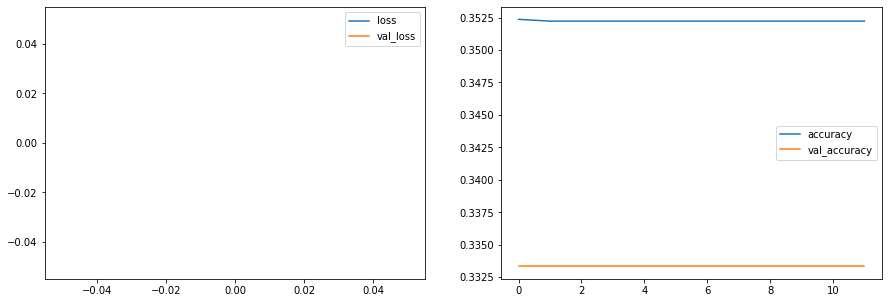

In [54]:
plot_model(history, 'acc')

### Model Evaluation (Accuracy)

In [55]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis = 1)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())   
loss, accuracy = model.evaluate(test_data)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

24/24 [==============================] - 9s 367ms/step - loss: nan - acc: 0.3333
Loss:  nan
Accuracy Score:  0.3333333432674408


### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [56]:
def get_confusion_matrix(data, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in data:
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    y_pred = np.argmax(p,axis = 1)
    predictions = np.concatenate((predictions, y_pred))
 
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break
  cm = confusion_matrix(targets, predictions)
  return cm

Generating confusion matrix 0


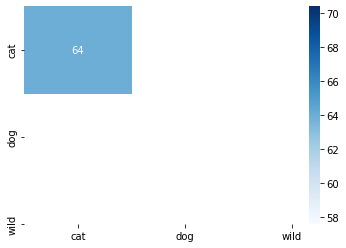

In [57]:
cm = get_confusion_matrix(test_data, len(test_image_files))
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=class_labels, 
            yticklabels= class_labels,
            cmap = plt.cm.Blues)
plt.show()

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [58]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

         cat       0.33      1.00      0.50       500
         dog       0.00      0.00      0.00       500
        wild       0.00      0.00      0.00       500

    accuracy                           0.33      1500
   macro avg       0.11      0.33      0.17      1500
weighted avg       0.11      0.33      0.17      1500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Creator: Ganapathi Thota , Github: [Profile](https://github.com/Shikiz)